### Download data from here: http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Downloads

## Params

In [1]:
import os

DATA_DIR = os.path.join(os.getcwd(),"datasetslib", "data")
NUM_CLASSES = 43
IMG_SIZE = 32

#Training Parameters
BATCH_SIZE =128
EPOCHS =1000
LEARNING_RATE = 0.001

# Inference Parameters
NUM_MONTE_CARLO = 50

## Data preprocess

In [2]:
import zipfile
import numpy as np
from skimage import color, exposure, transform
from skimage import io
import os
import glob
import pickle
import random
import pandas as pd
import seaborn as sns
from absl import flags
import matplotlib.pyplot as plt
from matplotlib import figure
import matplotlib.gridspec as gridspec
from matplotlib.backends import backend_agg
import tensorflow as tf


FLAGS = flags.FLAGS

def extract_dataset():
    # Extracting training data
    if not os.path.exists(os.path.join(DATA_DIR, "GTSRB")):
        zip_ref = zipfile.ZipFile(os.path.join(DATA_DIR, 'GTSRB_Final_Training_Images.zip'), 'r')
        zip_ref.extractall(DATA_DIR)
        zip_ref.close()
        # Extracting Testing Data
        zip_ref = zipfile.ZipFile(os.path.join(DATA_DIR, 'GTSRB_Final_Test_Images.zip'), 'r')
        zip_ref.extractall(DATA_DIR)
        zip_ref.close()
        # Extracting the csv file which contains annotations
        zip_ref = zipfile.ZipFile(os.path.join(DATA_DIR,'GTSRB_Final_Test_GT.zip'), 'r')
        zip_ref.extractall(os.path.join(DATA_DIR,"GTSRB"))
    else:
        print ("Data is already extracted in a folder. No need to extract from zipfile again")

def normalize_and_reshape_img(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # Crop of the centre
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]
    # Rescale to the desired size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

def get_class(img_path):
    try:
        return int(img_path.split('/')[-2])
    except:
        return int(img_path.split('\\')[-2])

def preprocess_and_save_data(data_type ='train'):
    '''
    Preprocesses image data and saves the image features and labels as pickle files to be used for the model
    :param data_type: data_type is 'train' or 'test'
    :return: None
    '''
    if data_type =='train':
        root_dir = os.path.join(DATA_DIR, 'GTSRB/Final_Training/Images/')
        imgs = []
        labels = []

        all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
        np.random.shuffle(all_img_paths)
        for img_path in all_img_paths:
            img = normalize_and_reshape_img(io.imread(img_path))
            label = get_class(img_path)
            imgs.append(img)
            labels.append(label)
        X_train = np.array(imgs, dtype='float32')
        # Make one hot targets
        Y_train = np.array(labels, dtype = 'uint8')

        train_data = {"features": X_train, "labels": Y_train}
        if not os.path.exists(os.path.join(DATA_DIR,"Preprocessed_Data")):
            os.makedirs(os.path.join(DATA_DIR,"Preprocessed_Data"))
        pickle.dump(train_data,open(os.path.join(DATA_DIR,"Preprocessed_Data","preprocessed_train.p"),"wb"))
        return train_data
    elif data_type == 'test':
        # Reading the test file
        test = pd.read_csv(os.path.join(DATA_DIR, "GTSRB", 'GT-final_test.csv'), sep=';')
        X_test = []
        y_test = []
        i = 0
        for file_name, class_id in zip(list(test['Filename']), list(test['ClassId'])):
            img_path = os.path.join(DATA_DIR, 'GTSRB/Final_Test/Images/', file_name)
            X_test.append(normalize_and_reshape_img(io.imread(img_path)))
            y_test.append(class_id)

        test_data = {"features": np.array(X_test,dtype ='float32'), "labels": np.array(y_test,dtype = 'uint8')}
        if not os.path.exists(os.path.join(DATA_DIR,"Preprocessed_Data")):
            os.makedirs(os.path.join(DATA_DIR,"Preprocessed_Data"))
        pickle.dump(test_data,open(os.path.join(DATA_DIR,"Preprocessed_Data","preprocessed_test.p"),"wb"))
        return test_data

def load_preprocessed_data():

    '''
    Load the preprocessed data if already present. Else, preprocess the data and then load
    :return:
    '''
    print ("Loading the training data")
    if not os.path.isfile(os.path.join(DATA_DIR, "Preprocessed_Data", "preprocessed_train.p")):
        print ("Processed File doesn't exist. Preprocessing data first")
        train_data = preprocess_and_save_data(data_type='train')
    else:
        train_data= pickle.load(open(os.path.join(DATA_DIR,"Preprocessed_Data","preprocessed_train.p"),"rb"))
    X_train, y_train = train_data['features'], train_data['labels']

    print ("Loading the testing data")
    if not os.path.isfile(os.path.join(DATA_DIR, "Preprocessed_Data", "preprocessed_test.p")):
        print ("Processed File doesn't exist. Preprocessing data first")
        test_data = preprocess_and_save_data(data_type='test')
    else:
        test_data= pickle.load(open(os.path.join(DATA_DIR,"Preprocessed_Data","preprocessed_test.p"),"rb"))
    X_test, y_test = test_data['features'], test_data['labels']

    return X_train, y_train, X_test,y_test


def convert_to_grayscale(data):
    data_gray = np.zeros((data.shape[0], data.shape[1], data.shape[2], 1))
    for i in range(len(data)):
        if i % 10000 == 0:
            print("Num images converted to grayscale ", i)
        temp = color.rgb2gray(data[i])
        temp = temp.reshape((temp.shape[0], temp.shape[1], 1))
        data_gray[i] = temp
    return data_gray.astype(np.float32)

def load_grayscale_images(data, data_type = 'train'):
    '''
    Converts the data to grayscale as we only care of classification and not the color of the traffic sign for now
    :param data: image data to be converted to grayscale
    :return: grayscale image/images
    '''
    if data_type == 'train':
        if not os.path.exists(os.path.join(DATA_DIR, "Preprocessed_Data", 'preprocessed_train_gray.p')):
            data_gray = convert_to_grayscale(data)
            # Saving the data_gray as pickle
            pickle.dump(data_gray, open(os.path.join(DATA_DIR, "Preprocessed_Data", "preprocessed_train_gray.p"), "wb"))
        else:
            data_gray = pickle.load(open(os.path.join(DATA_DIR, "Preprocessed_Data", "preprocessed_train_gray.p"), "rb"))
    elif data_type == 'test':
        if not os.path.exists(os.path.join(DATA_DIR, "Preprocessed_Data", 'preprocessed_test_gray.p')):
            data_gray = convert_to_grayscale(data)
            # Saving the data_gray as pickle
            pickle.dump(data_gray, open(os.path.join(DATA_DIR, "Preprocessed_Data", "preprocessed_test_gray.p"), "wb"))
        else:
            data_gray = pickle.load(open(os.path.join(DATA_DIR, "Preprocessed_Data", "preprocessed_test_gray.p"), "rb"))

    return data_gray


def build_data_pipeline(X_train, X_test,y_train, y_test):
    '''
    Dataset iterator for training the model
    :param X_train: Numpy array consisting of train images
    :param X_test: Numpy array consisting of test images
    :param y_train: Numpy array containing train labels
    :param y_test: Numpy arrray containing test labels
    :return: iterators for train and test
    '''

    train_data = tf.data.Dataset.from_tensor_slices((np.float32(X_train), np.int32(y_train)))
    train_batches = train_data.shuffle(50000, reshuffle_each_iteration=True).repeat().batch(BATCH_SIZE)
    train_iterator = train_batches.make_one_shot_iterator()

    # Building an iterator with test_dataset with batch_size = X_test.shape[0]. We use entire testing data for one shot iterator
    test_data = tf.data.Dataset.from_tensor_slices((np.float32(X_test),np.int32(y_test)))
    test_frozen = (test_data.take(X_test.shape[0]).repeat().batch(X_test.shape[0]))
    test_iterator = test_frozen.make_one_shot_iterator()

    # Combine these into a feedable iterator that can switch between training
    # and validation inputs.
    iter_handle = tf.placeholder(tf.string, shape=[])
    iterator_feed = tf.data.Iterator.from_string_handle(iter_handle, train_batches.output_types, train_batches.output_shapes)
    images, labels = iterator_feed.get_next()

    return images, labels, iter_handle, train_iterator, test_iterator



def plot_input_data(X_train,y_train):
    # Let's plot the images of a particular sign and see the differences
    num_rows = 9
    num_cols = 5

    fig = plt.figure(figsize=(num_cols, num_rows))
    gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.0)
    ax = [plt.subplot(gs[i]) for i in range(num_rows * num_cols)]
    for i in range(num_rows * num_cols):
        ax[i].axis('off')
        if i < 43:
            indexes = list(np.where(y_train == i))[0]
            image = X_train[random.choice(indexes)]
            ax[i].imshow(image, interpolation='nearest')

    image_name = 'Input_Images.png'
    if not os.path.exists(os.path.join(DATA_DIR, "..", "plots")):
        os.makedirs(os.path.join(DATA_DIR, "..", "plots"))
    fig.savefig(os.path.join(DATA_DIR, "..", "plots",image_name), dpi=fig.dpi)
    plt.clf()

def plot_weight_posteriors(names, qm_vals, qs_vals, fname):
    """Save a PNG plot with histograms of weight means and stddevs.
    Args:
        names: A Python `iterable` of `str` variable names.
        qm_vals: A Python `iterable`, the same length as `names`,
          whose elements are Numpy `array`s, of any shape, containing
          posterior means of weight variables.
        qs_vals: A Python `iterable`, the same length as `names`,
          whose elements are Numpy `array`s, of any shape, containing
          posterior standard deviations of weight varibles.
        fname: Python `str` filename to save the plot to.
    """
    fig = figure.Figure(figsize=(6, 3))
    canvas = backend_agg.FigureCanvasAgg(fig)

    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(qm.flatten(), ax=ax, label=n)
    ax.set_title("Mean of Weight")
    ax.set_xlim([-1.5, 1.5])
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(qs.flatten(), ax=ax)
    ax.set_title("Stdev of Weights")
    ax.set_xlim([0, 1.])

    fig.tight_layout()
    save_dir = os.path.join(DATA_DIR, "..","plots")
    canvas.print_figure(os.path.join(save_dir, fname), format="png")
    print("saved {}".format(fname))


def plot_heldout_prediction(input_vals, probs,
                            fname,  title=""):
    """Plotting uncertainity in prediction of a sampled image .
    Args:
        input_vals: A `float`-like Numpy `array` of shape
          IMAGE_SHAPE`, containing a sampled test image.
        probs: A `float`-like Numpy array of shape `[num_monte_carlo,
          1, num_classes]` containing Monte Carlo samples of
          class probabilities for a test image.
        fname: Python `str` filename to save the plot to.
        title: Python `str` title for the plot.
    """
    save_dir = os.path.join(DATA_DIR, "..", "plots")
    fig = figure.Figure(figsize=(1, 1))
    canvas = backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(1,1,1)
    ax.imshow(input_vals.reshape((IMG_SIZE,IMG_SIZE)), interpolation="None")
    canvas.print_figure(os.path.join(save_dir, fname + "_image.png"), format="png")

    fig = figure.Figure(figsize=(10, 5))
    canvas = backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(1,1,1)
    #Predictions
    y_pred_list = list(np.argmax(probs,axis=1).astype(np.int32))
    bin_range = [x for x in range(43)]
    ax.hist(y_pred_list,bins = bin_range)
    ax.set_xticks(bin_range)
    ax.set_title("Histogram of predicted class: " + title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Frequency")
    fig.tight_layout()
    save_dir = os.path.join(DATA_DIR, "..", "plots")
    canvas.print_figure(os.path.join(save_dir, fname + "_predicted_class.png"), format="png")
    print("saved {}".format(fname))
    

## Build a Bayesian NN & Run

Extracting dataset from zip files
Data is already extracted in a folder. No need to extract from zipfile again
Loading the training data
Loading the testing data
Shape of X_train is  (39209, 32, 32, 3)
Shape of X_test is  (12630, 32, 32, 3)
Shape of y_train is  (39209,)
Shape of y_test is  (12630,)
Shape of X_train Grayscale is  (39209, 32, 32, 1)
Shape of X_test is Grayscale (12630, 32, 32, 1)
Preprocessing Done
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch:   0 Loss: 27.534 Accuracy: 0.031
Epoch:   5 Loss: 27.352 Accuracy: 0.030
Epoch:  10 Loss: 27.283 Accuracy: 0.033
Epoch:  15 Loss: 27.241 Accuracy: 0.036
Epoch:  20 Loss: 27.128 Accuracy: 0.042
Epoch:  25 Loss: 27.061 Accuracy: 0.046
Epoch:  30 Loss: 26.970 Accuracy: 0.049
Epoch:  35 Loss: 27.011 Accuracy: 0.050
Epoch:  40 Loss: 26.903 Accuracy: 0.051
Epoch:  45 Loss: 26.835 Accuracy: 0.054
Epoch:  50 Loss

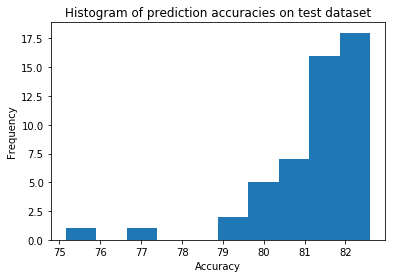

In [4]:
import warnings
import tensorflow_probability as tfp

tfd = tfp.distributions
warnings.filterwarnings("ignore")

def build_model(images):
    '''
    Defining a LeNet model for traffic sign classification
    :param images:
    :return: defined model
    '''
    with tf.name_scope("BNN", values=[images]):
        model = tf.keras.Sequential([
            tfp.layers.Convolution2DFlipout(10,
                                            kernel_size=5,
                                            padding="VALID",
                                            activation=tf.nn.relu),
            tf.keras.layers.MaxPooling2D(pool_size=[3, 3],
                                         strides=[1, 1],
                                         padding="VALID"),
            tfp.layers.Convolution2DFlipout(15,
                                            kernel_size=3,
                                            padding="VALID",
                                            activation=tf.nn.relu),
            tf.keras.layers.MaxPooling2D(pool_size=[2, 2],
                                         strides=[2, 2],
                                         padding="VALID"),
            tfp.layers.Convolution2DFlipout(30,
                                            kernel_size=3,
                                            padding="VALID",
                                            activation=tf.nn.relu),

            tf.keras.layers.MaxPooling2D(pool_size=[2, 2],
                                         strides=[2, 2],
                                         padding="VALID"),

            tf.keras.layers.Flatten(),
            tfp.layers.DenseFlipout(400, activation=tf.nn.relu),
            tfp.layers.DenseFlipout(120, activation = tf.nn.relu),
            tfp.layers.DenseFlipout(84, activation=tf.nn.relu),
            tfp.layers.DenseFlipout(43) ])

        logits = model(images)
        targets_distribution = tfd.Categorical(logits=logits)

    return model,logits, targets_distribution


def main():
    #del argv #unused
    print ("Extracting dataset from zip files")
    extract_dataset()
    X_train, y_train, X_test,y_test= load_preprocessed_data()
    X_train_gray = load_grayscale_images(X_train)
    X_test_gray = load_grayscale_images(X_test,data_type ='test')

    # Shape of the dataset
    print("Shape of X_train is ", X_train.shape)
    print("Shape of X_test is ", X_test.shape)
    print("Shape of y_train is ", y_train.shape)
    print("Shape of y_test is ", y_test.shape)

    print("Shape of X_train Grayscale is ", X_train_gray.shape)
    print("Shape of X_test is Grayscale", X_test_gray.shape)
    print("Preprocessing Done")

    # Plotting the input data
    #plot_input_data(X_train,y_train)

    # Data Pipeline for modeling
    (images, targets, iter_handle,
     train_iterator, test_iterator) = build_data_pipeline(X_train_gray, X_test_gray,y_train, y_test)

    #Building Model
    model, logits, targets_distribution =build_model(images)

    # Compute the -ELBO as the loss, averaged over the batch size.
    neg_log_likelihood = -tf.reduce_mean(targets_distribution.log_prob(targets))
    kl = sum(model.losses) / X_train.shape[0]
    elbo_loss = neg_log_likelihood + kl

    # Defining metrics for evalution
    predictions = tf.argmax(logits, axis=1)
    accuracy, accuracy_update_op = tf.metrics.accuracy(
        labels=targets, predictions=predictions)

    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
        train_op = optimizer.minimize(elbo_loss)

    # Extract weight posterior statistics for layers with weight distributions
    # for later visualization.
    names = []
    qmeans = []
    qstds = []
    for i, layer in enumerate(model.layers):
        try:
            q = layer.kernel_posterior
        except AttributeError:
            continue
        names.append("Layer {}".format(i))
        qmeans.append(q.mean())
        qstds.append(q.stddev())

    # Initialize the variables
    init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())

    with tf.Session() as sess:
        sess.run(init_op)

        # Run the training loop.
        train_handle = sess.run(train_iterator.string_handle())
        test_handle = sess.run(test_iterator.string_handle())
        for step in range(EPOCHS):
            _ = sess.run([train_op, accuracy_update_op],
                         feed_dict={iter_handle: train_handle})

            if step % 5== 0:
                loss_value, accuracy_value = sess.run(
                    [elbo_loss, accuracy], feed_dict={iter_handle: train_handle})
                print("Epoch: {:>3d} Loss: {:.3f} Accuracy: {:.3f}".format(
                    step, loss_value, accuracy_value))

        #Sampling from the posterior and obtaining mean probability for held out dataset
        probs = np.asarray([sess.run((targets_distribution.probs),
                                     feed_dict={iter_handle: test_handle})
                            for _ in range(NUM_MONTE_CARLO)])
        mean_probs = np.mean(probs, axis=0)

        test_acc_dist = []
        for prob in probs:
            y_test_pred = np.argmax(prob, axis=1).astype(np.float32)
            accuracy = (y_test_pred == y_test).mean() * 100
            test_acc_dist.append(accuracy)

        plt.hist(test_acc_dist)
        plt.title("Histogram of prediction accuracies on test dataset")
        plt.xlabel("Accuracy")
        plt.ylabel("Frequency")
        save_dir = os.path.join(DATA_DIR, "..", "plots")
        plt.savefig(os.path.join(save_dir,  "Test_Dataset_Prediction_Accuracy.png"))

        # Get the average accuracy
        Y_pred = np.argmax(mean_probs, axis=1)
        print("Overall Accuracy in predicting the test data =  percent", round((Y_pred == y_test).mean() * 100,2))
        # Draw two random samples from the test data
        sample_images_idx= np.random.choice(range(X_test_gray.shape[0]), size=10)
        for i in sample_images_idx:
            sampled_image = X_test_gray[i]
            sample_label = y_test[i]
            mean_prediction = Y_pred[i]
            plot_heldout_prediction(sampled_image, probs[:,i,:],
                                    fname="Sample{:05d}_pred".format(i),
                                    title="Correct Label {:02d}, Mean Prediction {:02d}"
                                    .format(sample_label,mean_prediction))

        qm_vals, qs_vals = sess.run((qmeans, qstds))

        # Plotting Weight Means and Standard deviation
        plot_weight_posteriors(names, qm_vals, qs_vals,
                               fname="step{:05d}_weights.png".format(step))

if __name__ == "__main__":
    main()
    